# H2: Human Handwriting

H2 is a dataset originally collected to develop a handwriting-based communication BCI. This data has been previously published in [Willett 2021, Nature](https://www.nature.com/articles/s41586-021-03506-2) and [Fan 2023, NeurIPS](https://proceedings.neurips.cc/paper_files/paper/2023/hash/83a14a36de4502bac5b580db36e81858-Abstract-Conference.html).

The dataset contains neural activity from participant T5, who gave informed consent and was enrolled in the BrainGate2 Neural Interface System clinical trial (ClinicalTrials.gov Identifier: NCT00912041, registered June 3, 2009). This pilot clinical trial was approved under an Investigational Device Exemption (IDE) by the US Food and Drug Administration (Investigational Device Exemption #G090003). Permission was also granted by the Institutional Review Boards of Stanford University (protocol #20804).

Data was recorded from two 96-channel intracortical electrode arrays in the hand "knob" area of of T5's left hemisphere precentral gyrus. 

# Task 
On each trial, T5 was prompted to copy a cued sentence by writing individual characters, separated by a ">" space character. Decoded letters appeared on the screen below the prompt.

# Use in FALCON
Handwriting decoding is a unique addition to the FALCON benchmark for two key reasons. First, it provides an avenue for developing methods for stable decoding in communication BCIs, and important and complementary goal to motor decoding BCIs. Additionally, the decoding problem is structured very differently than for motor tasks; it requires identifying regions of a continuous time series that correspond to individual characters and classifying the identity of those characters.

In [1]:
import copy
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pynwb import NWBHDF5IO
from styleguide import set_style

set_style()

/tmp/ipykernel_344613/3053767689.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data collection

We collected 26 sessions of handwriting data, details about each sesssion can be found [here](https://proceedings.neurips.cc/paper_files/paper/2023/file/83a14a36de4502bac5b580db36e81858-Supplemental-Conference.pdf).

Sessions `2022-05-18` to `2022-09-01` were collected for training a seed model decoder. Each session contains several open-loop blocks where T5 copied sentences via attempted handwriting.
Sessions `2022-09-29` to `2023-10-09` were for evaluating the online recalibration algorithm [CORP](https://proceedings.neurips.cc/paper_files/paper/2023/hash/83a14a36de4502bac5b580db36e81858-Abstract-Conference.html). Each session contains closed-loop blocks where T5 copied sentences and saw real-time decoded characters, while CORP ran in the background to recalibrate the decoder.

## Data splits

For this benchmark, sessions `2022-05-18` to `2023-02-28` are partitioned into `held_in` to training the seed model decoder. Sessions `2023-04-17` to `2023-10-09` are partitioned into `held_out` to evaluate the stability of the seed decoder and benchmark few-shot fine-tuning stategies for mitigating nonstationarity.

In [4]:
train_path = Path('../data/h2/held_in_calib')
test_path = Path('../data/h2/held_out_calib')

train_files = sorted(train_path.glob('*.nwb'))
test_files = sorted(test_path.glob('*.nwb'))

def get_start_date_and_volume(fn: Path):
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()
        start_date = nwbfile.session_start_time.strftime('%Y.%m.%d') # full datetime to just date
        timestamps = nwbfile.acquisition['binned_spikes'].timestamps 

    return pd.to_datetime(start_date), timestamps.shape[0]

start_dates, volume = zip(*[get_start_date_and_volume(fn) for fn in train_files + test_files])
split_type = ['Train'] * len(train_files) + ['Test'] * len(test_files) 

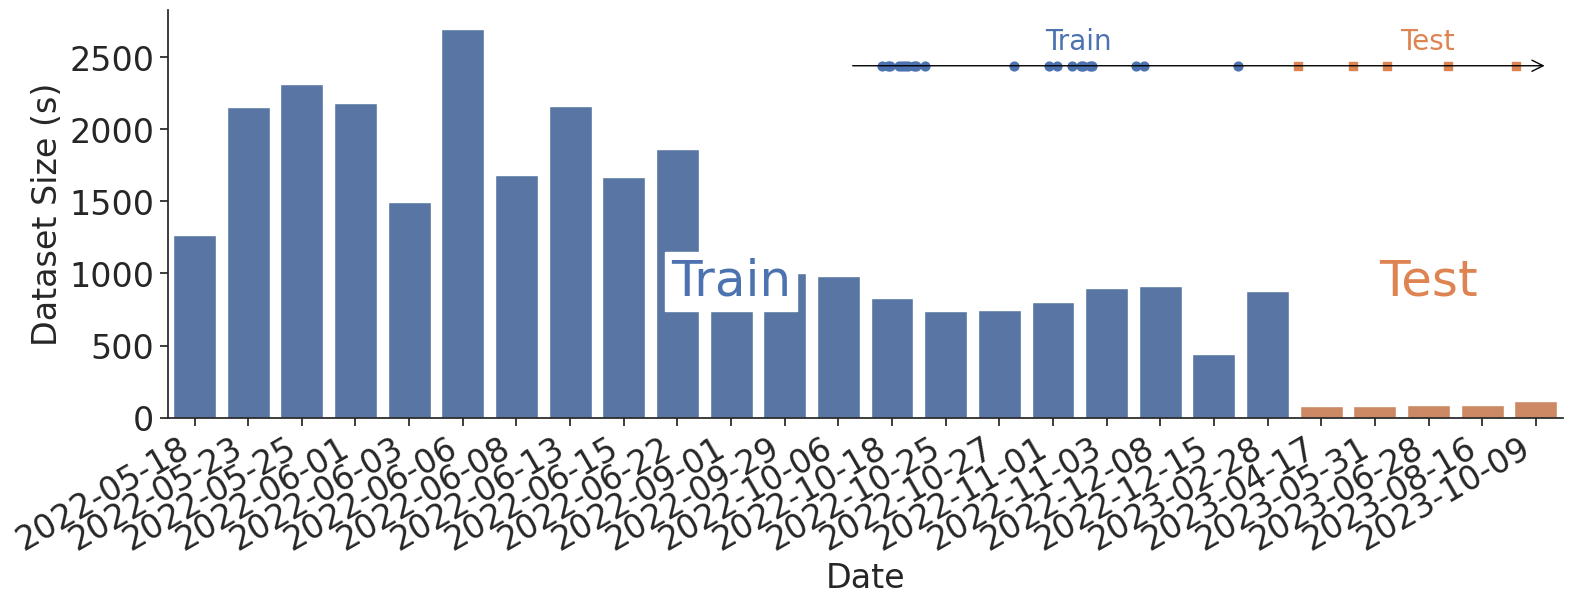

In [5]:
from visualization import plot_split_bars, plot_timeline

BIN_SIZE_S = 0.02
fig, ax = plt.subplots(figsize=(18, 6))

df = pd.DataFrame({'Date_Full': start_dates, 'Dataset Size': volume, 'Split Type': split_type})
# just get month and day
df['Dataset Size (s)'] = df['Dataset Size'] * BIN_SIZE_S
df['Date'] = df['Date_Full'].dt.strftime('%Y-%m-%d')

plot_split_bars(df, fig, ax)

sections = df.groupby(
    'Split Type'
)['Date'].apply(list).to_dict()
# sort section by section name, respect Train, Test Short, Test Long order
sections = {k: v for k, v in sorted(sections.items(), key=lambda item: item[1])}

plot_timeline(ax, sections, year=None)

# Quick Overview

The data contained in these files is already trialized, and contains spikes binned in 20ms bins with the sentences cued for each corresponding trial.

Here we will visualize the experimental data. We will first load the NWB files and then plot the binned spikes.

In [6]:
def load_nwb(fn: str):
    print(f'Loading {fn}')
    with NWBHDF5IO(fn, 'r') as io:
        nwbfile = io.read()

        trial_info = (
            nwbfile.trials.to_dataframe()
            .reset_index()
        )

        binned_spikes = nwbfile.acquisition['binned_spikes'].data[()]
        time = nwbfile.acquisition['binned_spikes'].timestamps[()]
        eval_mask = nwbfile.acquisition['eval_mask'].data[()].astype(bool)

    return(
        binned_spikes,
        time,
        trial_info,
        eval_mask
    )

spikes, time, tinfo, eval_mask = load_nwb(train_files[0])

Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.05.18_held_in_calib.nwb


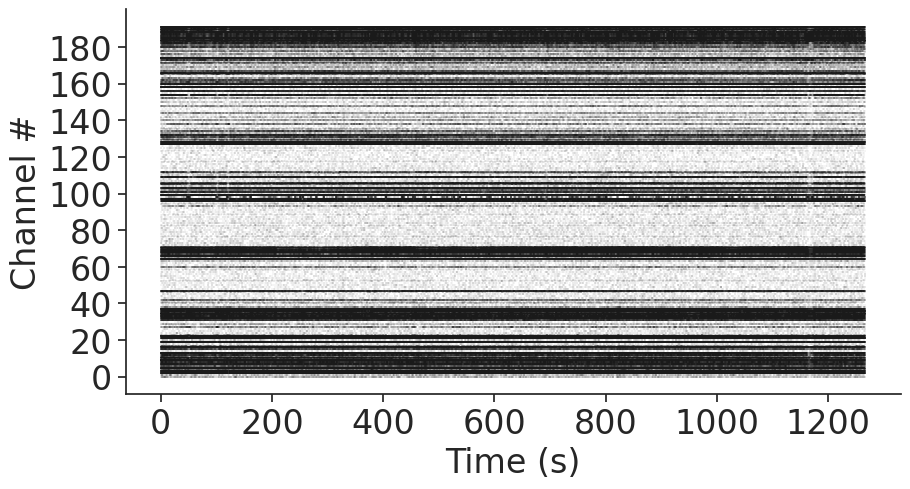

In [7]:
# %% plot some continuous raster/EMG data for a single session
from visualization import rasterplot
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
rasterplot(spikes, bin_size_s=BIN_SIZE_S, ax=ax)
ax.set_xlabel('Time (s)')
plt.show()

In [8]:
# some example sentence cues 
for tr in range(5): 
    print(f'Trial {tr} cue: ' + tinfo.iloc[tr]['cue'])

# print unique characters in the dataset
unique_chars = sorted(list(set(tinfo['cue'].str.cat())))
print(f'Dataset contains {len(unique_chars)} unique characters: {unique_chars}')

Trial 0 cue: there>just>might>be>too>many>people>there~
Trial 1 cue: he>was>an>important>man>in>his>village~
Trial 2 cue: see>a>doctor
Trial 3 cue: the>royal>navy>had>left>its>mark~
Trial 4 cue: would>you>like>me>to>check>the>mail?
Dataset contains 31 unique characters: ["'", ',', '>', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '~']


# Neural activity statistics change over time 

The neural activity in these datasets consist of multiunit threshold crossings, putatively attributed to nearby spiking activity.

The statistics of neural activity are stable over the course of a single calibration period, but can be quite unstable over the course of multiple days. We see that simply by plotting the raw neural activity from consecutive days together. Instabilities can for example be attributed by given channels being more or less active on a given day, even though these channels _provide decoding signal_ on that day.

In [11]:
# load each day's data 
binned_neural = {}
metadata = {}
lengths = {}
times = {}
masks = {}

for f in train_files + test_files: 
    spikes, time, tinfo, eval_mask = load_nwb(f)
    key = f.name.split('_')[1]
    binned_neural[key] = spikes
    lengths[key] = spikes.shape[0]
    metadata[key] = tinfo
    times[key] = time
    masks[key] = eval_mask

all_binned_neural = np.vstack([binned_neural[bn] for bn in binned_neural])

Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.05.18_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.05.23_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.05.25_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.06.01_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.06.03_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.06.06_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_in_calib/T5_2022.06.08_held_in_calib.nwb
Loading /snel/share/share/data/bg2/t5_handwriting/CORP_data/stability_benchmark/nwb/held_i

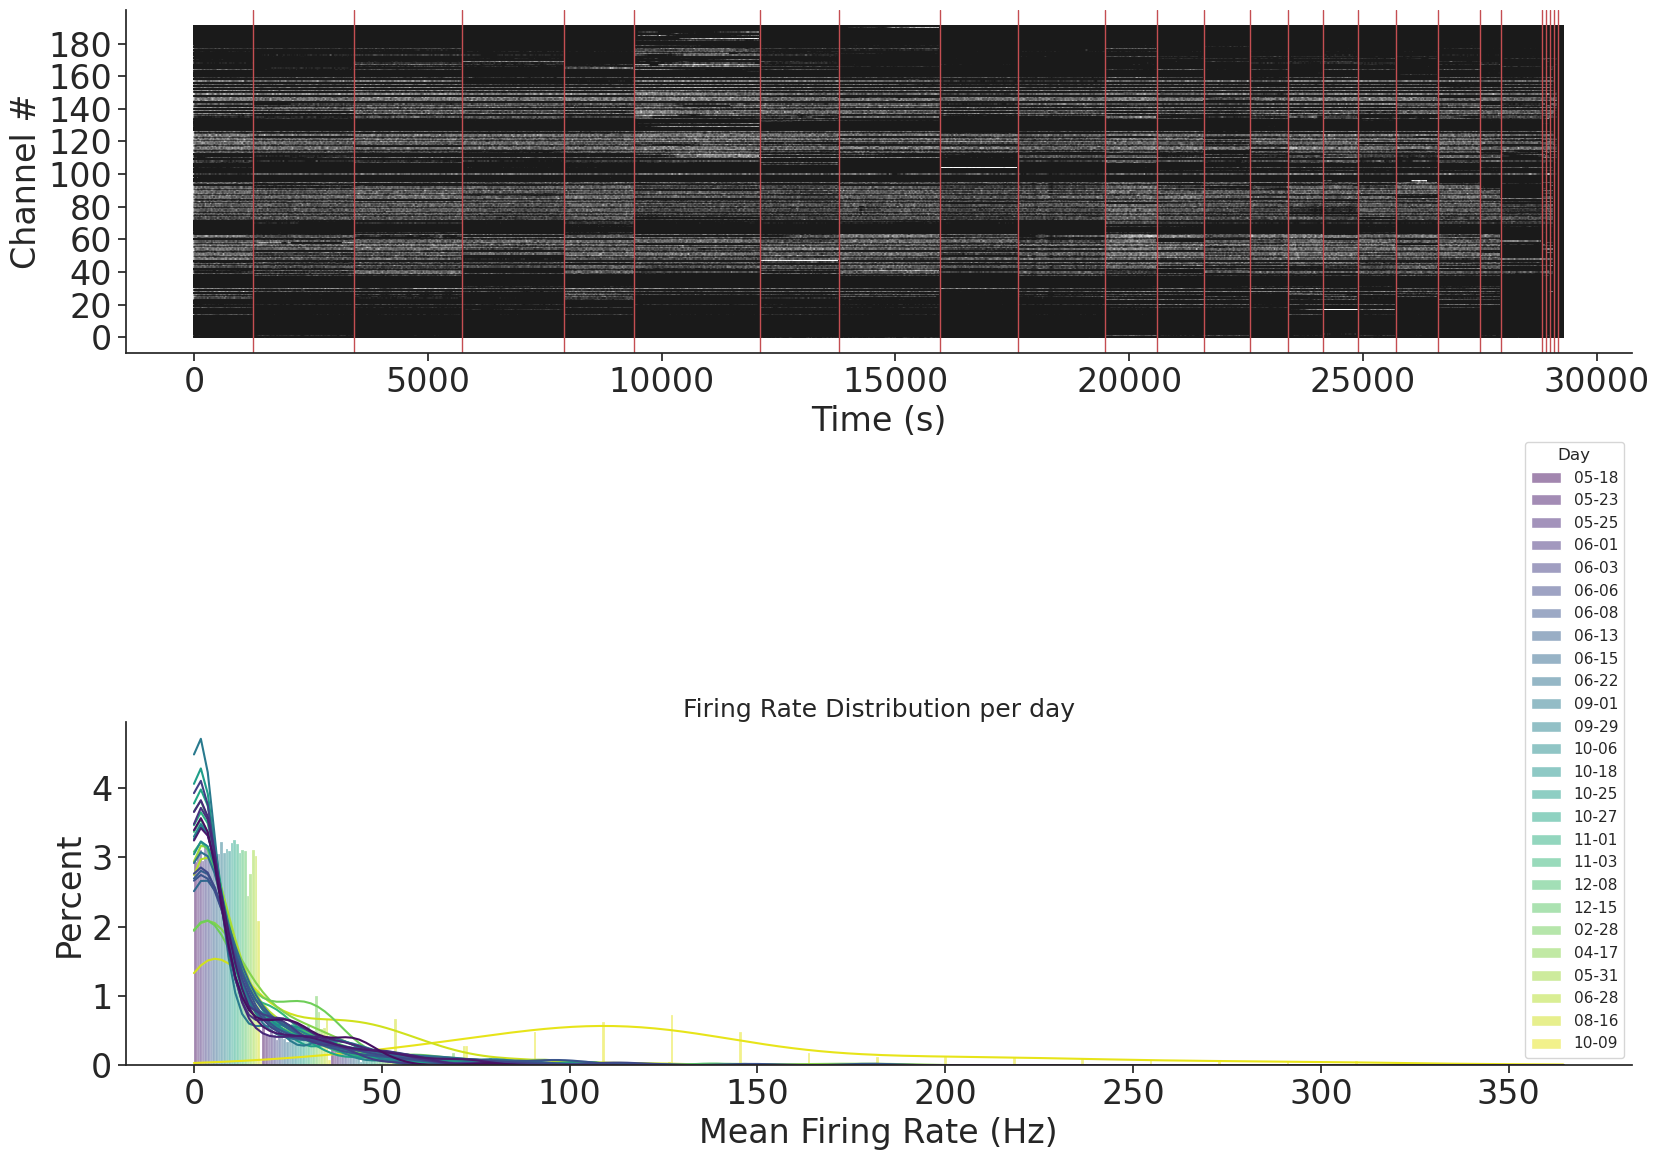

In [18]:
# Plot snippets of multiple days back to back to note change in structure
from visualization import plot_firing_rate_distributions 

f, axes = plt.subplots(2, 1, figsize=(17,12), layout='tight')

rasterplot(all_binned_neural, ax=axes[0])
day_intervals = np.cumsum([lengths[bn] for bn in binned_neural])

for i, length in enumerate(day_intervals[:-1]):
    axes[0].axvline(x = length * BIN_SIZE_S, color='r', linewidth=1)
axes[0].set_xlabel('Time (s)')

plot_firing_rate_distributions(lengths, all_binned_neural, start_dates, axes[1])

# Training and evaluating a decoder 

The FALCON benchmark measures decoding performance from neural data. Here we present a handwriting decoder installed from https://github.com/cffan/CORP/tree/master/NeuralDecoder. 

Note that we provide multiple days of training data. Decodability may vary across these days. Current practice with this RNN decoder involves training the decoder on all available seed datasets. Data from the `held_in_calib` partition is used to train and evlauate the seed decoder model. We use the `held_out_calib` partition to show the performance degradation on a new day due to nonstationarity.

**Before running this section, make sure you install the `NeuralDecoder` above, and download formatted data and pretrained model from [here](https://office365stanford-my.sharepoint.com/:f:/g/personal/stfan_stanford_edu/EjtvQJBY7PhHlqrObHj_MGUBi_mATkwRZ0F0nW8Ujk3iaQ?e=5N45sc).**

Details about data formatting and decoder training can be found [here](). 

In [2]:
# Evaluate on held-in data

from omegaconf import OmegaConf
import tensorflow as tf
from neuralDecoder.neuralSequenceDecoder import NeuralSequenceDecoder
from neuralDecoder.datasets import HandwritingDataset

# Set up model and data paths
model_dir = '/oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_minival/model' 
tfrecords_dir = '/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/held_in_tfrecords/'

# Load model
args = OmegaConf.load(os.path.join(model_dir, 'args.yaml'))
args['mode'] = 'infer'
args['loadCheckpointIdx'] = 17000
args['outputDir'] = model_dir
args['dataset']['dataDir'] = [tfrecords_dir] * len(args['dataset']['dataDir'])
tf.compat.v1.reset_default_graph()
nsd = NeuralSequenceDecoder(args)

# Inference
held_in_results = nsd.inference()
print(f"CER: {held_in_results['cer']:0.4f}")

2024-03-29 15:35:50.491585: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 15:35:50.861505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79054 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:81:00.0, compute capability: 8.0


Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_minival/model/ckpt-17000


2024-03-29 15:35:54.701312: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-29 15:35:54.713875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8600


CER: 0.0335


In [3]:
# Evaluate on held-out data

held_out_tfrecords_dir = '/oak/stanford/groups/henderj/stfan/code/CORP/FalconChallenge/data/held_out_demo_tfrecords/'

held_out_sessions = ['2023.04.17', '2023.05.31', '2023.06.28', '2023.08.16', '2023.10.09']
held_out_cers = []
for session in held_out_sessions:
    new_args = copy.deepcopy(args)
    new_args['dataset']['sessions'] = args['dataset']['sessions'] + [session]
    new_args['dataset']['datasetToLayerMap'] = args['dataset']['datasetToLayerMap'] + [20]  # Use previous session's input layer
    new_args['dataset']['datasetProbabilityVal'] = [0] * 21 + [1]  # Only eval on the new session
    new_args['dataset']['dataDir'] = [tfrecords_dir] * 21 + [held_out_tfrecords_dir] * 1

    tf.compat.v1.reset_default_graph()
    nsd = NeuralSequenceDecoder(new_args)

    held_out_results = nsd.inference()
    print(f"CER: {held_out_results['cer']:0.4f}")
    held_out_cers.append(held_out_results['cer'])

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple                  1084416   
                                                                 
 gru_2 (GRU)                 multiple                  1575936   
                                                                 
 dense (Dense)               multiple                  16416     
                                                                 
Total params: 2,677,280
Trainable params: 2,677,280
Non-trainable params: 0
_________________________________________________________________
Loading from : /oak/stanford/groups/henderj/stfan/logs/handwriting_logs/corp_falcon_seed_model_minival/model/ckpt-17000
CER: 0.2644
Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 multiple   

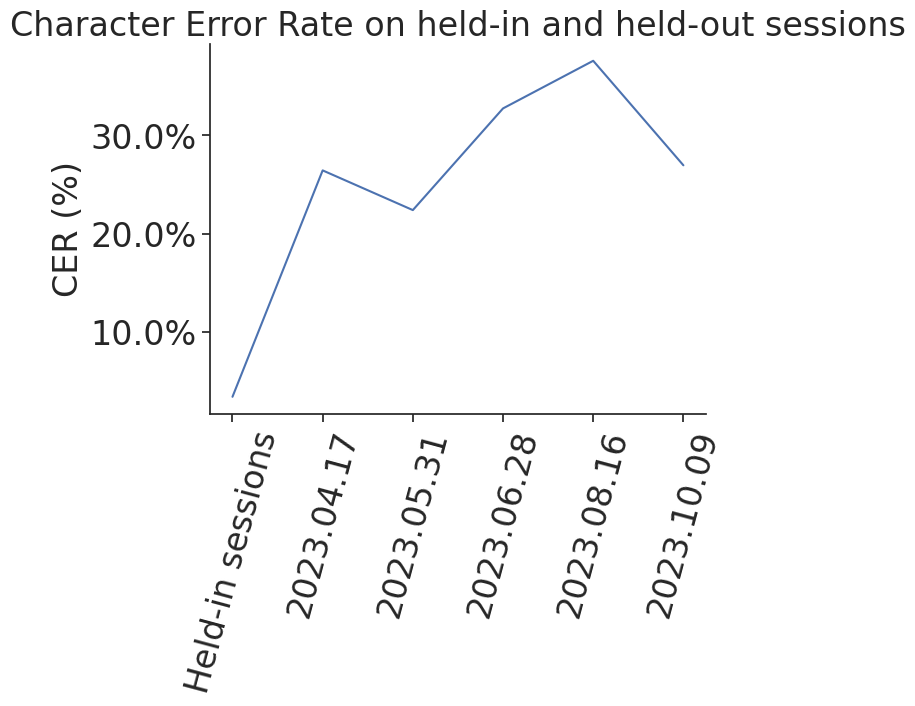

In [4]:
import matplotlib.ticker as mtick

plot_data = pd.DataFrame({
    'session': ['Held-in sessions'] + held_out_sessions,
    'cer': [held_in_results['cer']] + held_out_cers
})

plt.figure()
sns.lineplot(data=plot_data, x='session', y='cer')
plt.ylabel('CER (%)')
plt.xlabel('')
plt.title('Character Error Rate on held-in and held-out sessions')
plt.xticks(rotation=75)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.show()